# Introducing Long-Range Forecasting MA Models using Numpy
## DS150 Time Series Analysis

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

For us to utilize forecasting, we would then reconstruct the forecasts with the decomposed model. As a simple example:

In [3]:
btc_data = pd.read_csv('btc_subset.csv', parse_dates=['date'], usecols=['date','close'])

In [4]:
btc_data.head()

,date,close
0,2018-10-31,6303.27
1,2018-10-30,6269.46
2,2018-10-29,6266.52
3,2018-10-28,6405.57
4,2018-10-27,6407.66


In [5]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    183 non-null    datetime64[ns]
 1   close   183 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


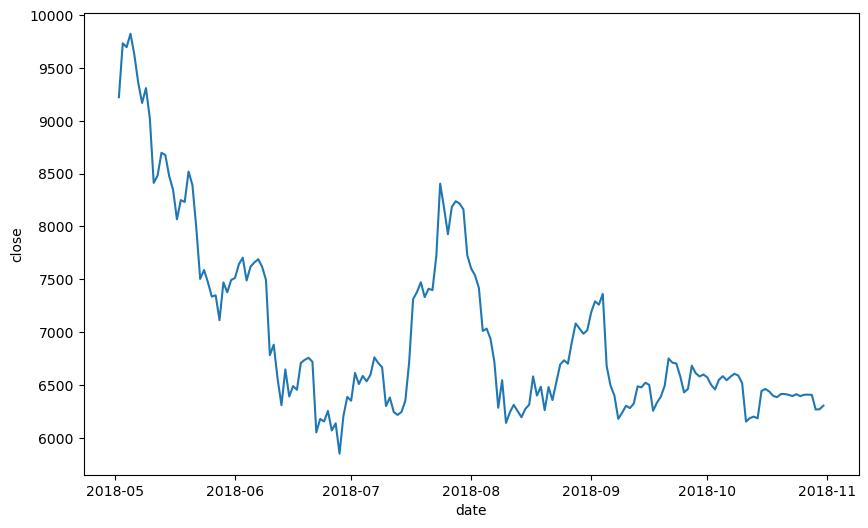

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=btc_data, x='date', y='close', ax=ax)

plt.show()

To forecase the given time series data, we would first decompose the time series by utilizing differencing and MA modeling. Take note that there are certain conditions to be met before doing the MA process.

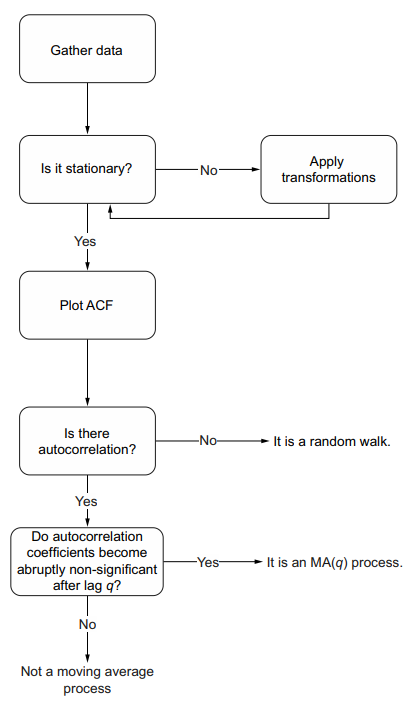

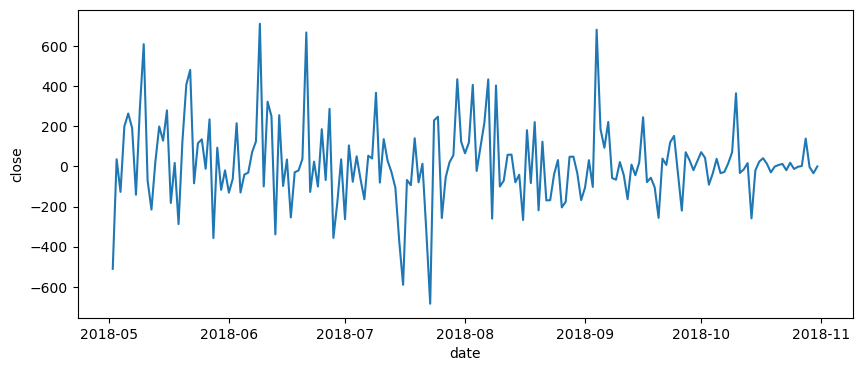

In [7]:
# Differencing to get stationary data

fig, ax = plt.subplots(figsize=(10,4))

sns.lineplot(x=btc_data['date'], y=btc_data['close'].diff().fillna(0), ax=ax)

plt.show()

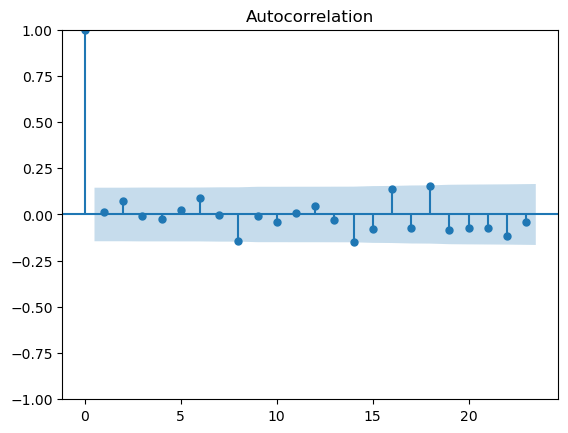

In [8]:
# Lags are significant at q=18

plot_acf(btc_data['close'].diff().fillna(0))

plt.show()

Since that the lags are at high when $q=16$ and $q=18$ but the latter seems to be at a higher correlation value, we would then use MA-18 in the process.

Before else, we would then store the differenced values.

In [9]:
diff_data = btc_data['close'].diff().fillna(0)
diff_data

0        0.00
1      -33.81
2       -2.94
3      139.05
4        2.09
        ...  
178    264.02
179    199.74
180   -126.71
181     35.86
182   -510.43
Name: close, Length: 183, dtype: float64

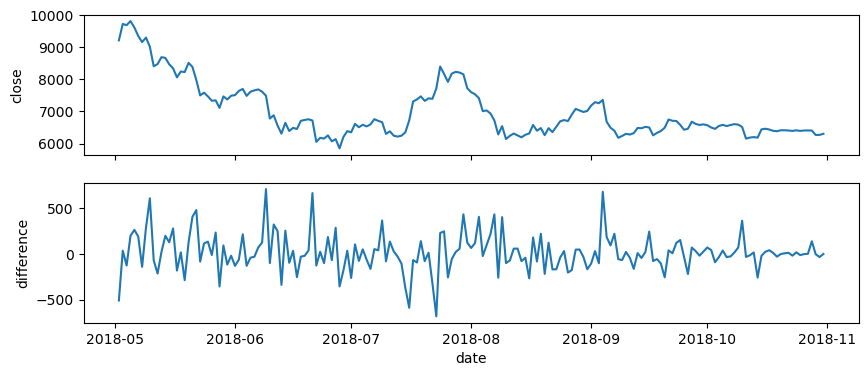

In [10]:
fig, ax = plt.subplots(nrows=2, figsize=(10,4), sharex=True)

sns.lineplot(x=btc_data['date'], y=btc_data['close'], ax=ax[0])
sns.lineplot(x=btc_data['date'], y=diff_data, ax=ax[1])

ax[1].set_ylabel('difference')

plt.show()

Afterwards, we would utilize `np.convolve()` as a trick to perform moving averages across the time series data.

In [11]:
# We would then compute for the moving average using MA-18

MA_Q = 18
conv_array = np.repeat(1/(MA_Q+1), MA_Q+1)
conv_array

array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158])

In [12]:
# Get bounds of the valid MA values
bound_val = int(MA_Q/2)
btc_data.iloc[bound_val:-bound_val,0]

9     2018-10-22
10    2018-10-21
11    2018-10-20
12    2018-10-19
13    2018-10-18
         ...    
169   2018-05-15
170   2018-05-14
171   2018-05-13
172   2018-05-12
173   2018-05-11
Name: date, Length: 165, dtype: datetime64[ns]

In [13]:
ma_data = np.convolve(diff_data, conv_array, mode='valid')
ma_data

array([  -5.45157895,   -6.21684211,   -6.14210526,   13.21210526,
          9.64368421,   10.37315789,    9.02789474,    7.92368421,
          8.95578947,    8.11315789,    2.66894737,    4.55894737,
          8.33368421,   11.28157895,    9.64210526,    9.13      ,
         11.60105263,    1.04052632,   12.94684211,   20.09631579,
         27.21421053,   29.32894737,   12.20526316,   -5.04315789,
        -11.38684211,  -12.91      ,  -15.24      ,   -4.32315789,
         -1.44263158,    1.03894737,   -0.75263158,  -13.09210526,
        -16.72736842,  -14.59947368,  -19.72210526,  -26.49      ,
         -3.23736842,    3.37368421,    5.14631579,   34.67263158,
         28.89368421,   28.46631579,   36.42263158,   33.10263158,
         34.29842105,   40.97052632,   30.57684211,   20.22947368,
         11.78684211,   12.98421053,   19.49947368,   12.89578947,
          2.83      ,   12.80157895,    4.34263158,    4.31526316,
         -4.93736842,   -5.21842105,  -55.13105263,  -51.93105

One drawback to this process is that the MA computation process via `np.convolve` would take the 9 values before and after the given timestep (total of 18), there will be numbers at the beginning and end of time series that are unavailable. Since the first and last 9 values would be not applicable as the data is insufficient for computing the MA-values.

Although, it is perfectly valid to compute for MA using the last 18 values in the time series. You may device a workaround to compute for the MA with the previous timesteps only.

Overall, the MA process would evolve to the following output. Notice that the red line is the values derived in the MA(18) process, which gradually change in correspond to the differenced values.

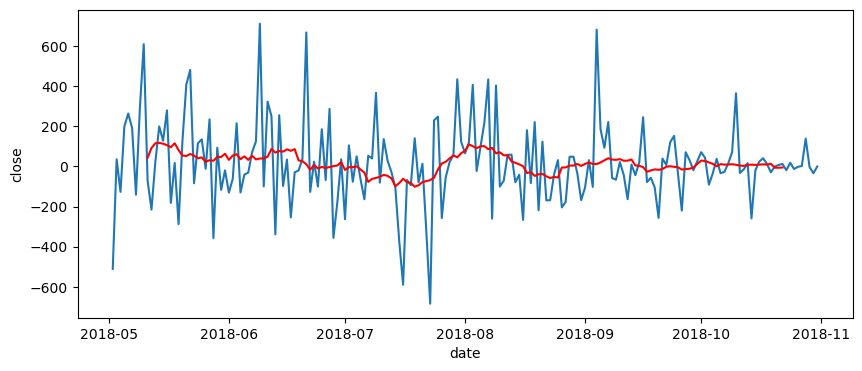

In [14]:
fig, ax = plt.subplots(figsize=(10,4))

sns.lineplot(x=btc_data['date'], y=diff_data, ax=ax)
sns.lineplot(x=btc_data.iloc[bound_val:-bound_val,0], y=ma_data, ax=ax, color='red')

plt.show()

After performing the MA process, we can compute for the residual values by subtracting the differenced data with the average value from the MA(18) process.

In [15]:
resid_data = diff_data.iloc[bound_val:-bound_val] - ma_data
resid_data

9       18.101579
10      13.536842
11       5.622105
12     -42.612105
13       3.076316
          ...    
169     15.117895
170     81.664737
171    -93.236842
172   -306.998421
173   -113.876842
Name: close, Length: 165, dtype: float64

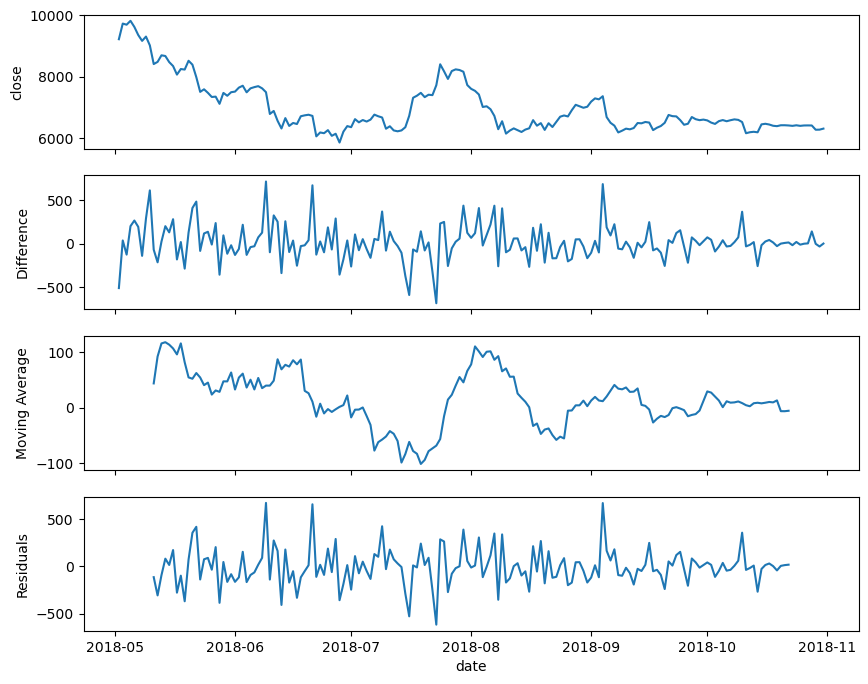

In [16]:
fig, ax = plt.subplots(nrows=4, figsize=(10,8), sharex=True)

sns.lineplot(x=btc_data['date'], y=btc_data['close'], ax=ax[0])
sns.lineplot(x=btc_data['date'], y=diff_data, ax=ax[1])
sns.lineplot(x=btc_data.iloc[bound_val:-bound_val,0], y=ma_data, ax=ax[2])
sns.lineplot(x=btc_data.iloc[bound_val:-bound_val,0], y=resid_data, ax=ax[3])

ax[1].set_ylabel('Difference')
ax[2].set_ylabel('Moving Average')
ax[3].set_ylabel('Residuals')

plt.show()

One particular characteristic about the residuals is that it follows a normal distribution. This means that if the given residuals follows such a distribution, then we have completely decomposed the given time series and we can use the residuals as part of our forecasting process.

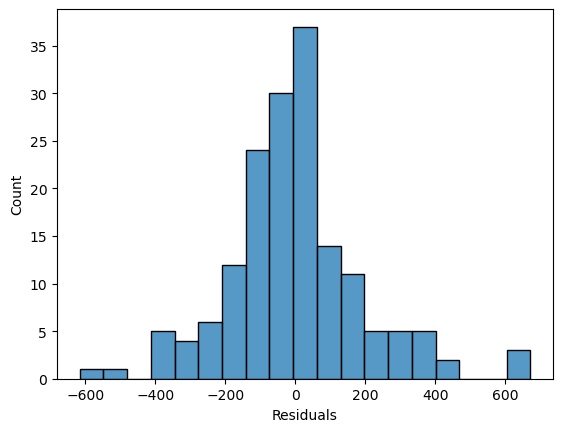

In [17]:
fig, ax = plt.subplots()

sns.histplot(x=resid_data, ax=ax)
ax.set_xlabel('Residuals')

plt.show()

### Activity: Forecasting using Residuals

Now that the decomposition is complete, we can then use the residuals to generate forecasts in the model.

Since the residuals follow the normal distribution, we can simulate the forecasting process using a familiar concept, namely...

***Bootstrapping***

#### Instructions

From bootstrap replicates from residual data, reverse-engineer the decomposition process to reach the forecast values in the data.

1. From the given residual data, generate `100` sets of `14` bootstrap replicates.
2. For each set in the replicates:
    - Compute for the next `14` average values in the MA(18) process (next values in `ma_data`). The next average value is computed through the average of the last 18 residual values, including the bootstrapped value.
    - Get the element-wise sum between the (first) `14` computed average values and the `14` bootstrap replicates to get the next `14` values in `diff_data`
    - Compute for the cumulative sum in `diff_data` to get the forecasted price.
    - Plot a forecast line on the computed forecast price.

3. With the 100 forecast lines on the plot, create another plot that only shows the highest, the lowest, and the average forecasted value for each day.


In [18]:
# Write your code here

In [24]:
num_replicates = 100

# Number of samples in each replicate
num_samples = 14

# Initialize an array to store the bootstrap replicates
bootstrap_replicates = np.zeros((num_replicates, num_samples))

# Generate bootstrap replicates
for i in range(num_replicates):
    # Resample the residual data with replacement
    bootstrap_sample = np.random.choice(resid_data, size=num_samples, replace=True)
    # Store the bootstrap sample in the array
    bootstrap_replicates[i] = bootstrap_sample

# Display the shape of the array (should be (100, 14))
print("Shape of bootstrap replicates array:", bootstrap_replicates.shape)


Shape of bootstrap replicates array: (100, 14)


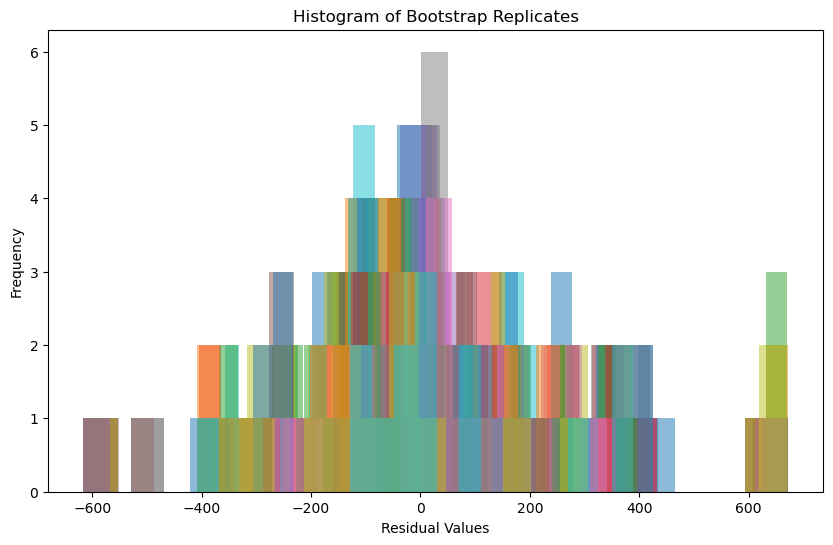

In [27]:
plt.figure(figsize=(10, 6))
for i in range(num_replicates):
    plt.hist(bootstrap_replicates[i], bins=20, alpha=0.5)

plt.title('Histogram of Bootstrap Replicates')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.show()

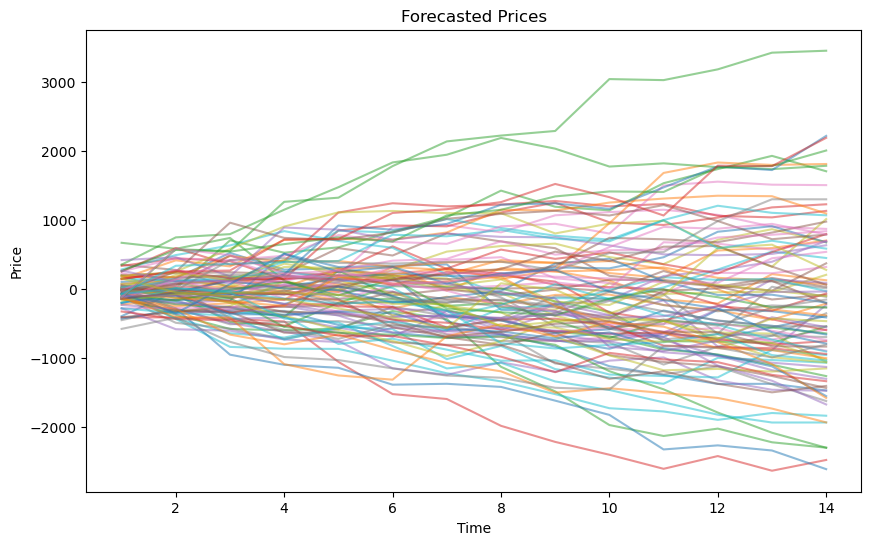

In [28]:
# Initialize an array to store the forecasted prices
forecast_prices = np.zeros((num_replicates, num_samples))

# Compute forecasted prices for each set of replicates
for i in range(num_replicates):
    # Compute the next 14 average values in the MA(18) process
    next_ma_values = np.convolve(np.append(resid_data[-18:], bootstrap_replicates[i]), conv_array, mode='valid')[:num_samples]
    
    # Get the element-wise sum between the first 14 computed average values and the bootstrap replicates
    next_diff_data = next_ma_values + bootstrap_replicates[i]
    
    # Compute the cumulative sum to get the forecasted price
    forecast_prices[i] = np.cumsum(next_diff_data)

# Plot the forecasted prices
plt.figure(figsize=(10, 6))
for i in range(num_replicates):
    plt.plot(np.arange(1, num_samples+1), forecast_prices[i], alpha=0.5)

plt.title('Forecasted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


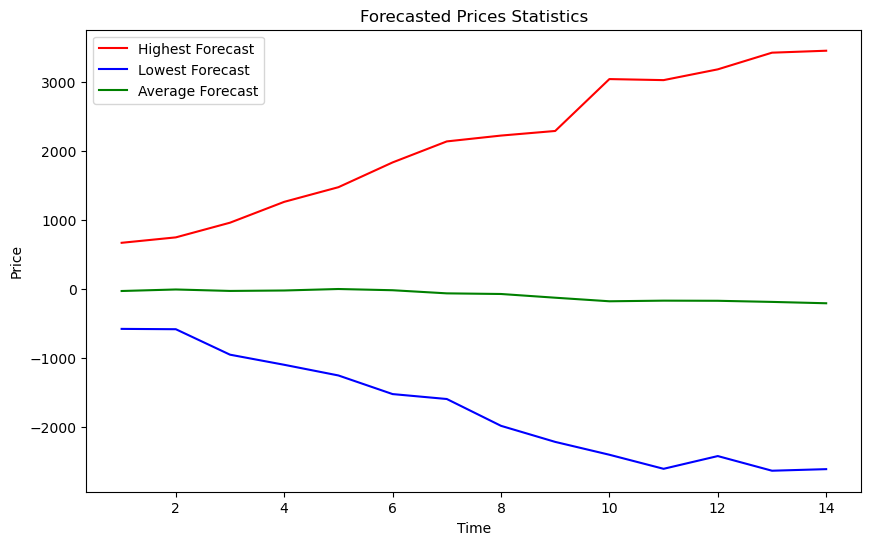

In [29]:
# Compute statistics for each day
highest_forecast = np.max(forecast_prices, axis=0)
lowest_forecast = np.min(forecast_prices, axis=0)
average_forecast = np.mean(forecast_prices, axis=0)

# Plot the statistics
plt.figure(figsize=(10, 6))

# Plot the highest forecast
plt.plot(np.arange(1, num_samples+1), highest_forecast, label='Highest Forecast', color='red')

# Plot the lowest forecast
plt.plot(np.arange(1, num_samples+1), lowest_forecast, label='Lowest Forecast', color='blue')

# Plot the average forecast
plt.plot(np.arange(1, num_samples+1), average_forecast, label='Average Forecast', color='green')

plt.title('Forecasted Prices Statistics')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
